In [463]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from enum import Enum

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [464]:
class Weapon(Enum):
    KNIFE = 1
    ODIN = 2
    ARES = 3
    VANDAL = 4
    BULLDOG = 5
    PHANTOM = 6
    JUDGE = 7
    BUCKY = 8
    FRENZY = 10
    CLASSIC = 11
    GHOST = 12
    SHERIFF = 13
    SHORTY = 14
    OPERATOR = 15
    GUARDIAN = 16
    MARSHAL = 17
    SPECTRE = 18
    STINGER = 19
    OUTLAW = 23

In [465]:
os.makedirs("models", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)

map_files = glob("datasets/consolidated_data/*_kill_data_consolidated.csv")
print(f'Found {len(map_files)} map data files:')
for file in map_files:
    print(f'- {os.path.basename(file)}')

Found 10 map data files:
- ascent_kill_data_consolidated.csv
- sunset_kill_data_consolidated.csv
- lotus_kill_data_consolidated.csv
- split_kill_data_consolidated.csv
- fracture_kill_data_consolidated.csv
- icebox_kill_data_consolidated.csv
- haven_kill_data_consolidated.csv
- pearl_kill_data_consolidated.csv
- abyss_kill_data_consolidated.csv
- bind_kill_data_consolidated.csv


In [466]:
def calculate_weapon_distance_advantage(attacker_weapon_id, defender_weapon_id, distance):
    """
    Calculate advantage based on weapon types at a given distance.
    Returns a numerical advantage score (positive favors attacker, negative favors defender).
    """
    knife = [1]  # Tier 0 (lowest)
    pistols = [11, 10, 12]  # Classic, Frenzy, Ghost - Tier 1
    upgraded_pistols = [13]  # Sheriff - Tier 2
    shotguns = [14, 7, 8]  # Shorty, Judge, Bucky - Tier 2
    smgs = [19, 18]  # Stinger, Spectre - Tier 3
    lmgs = [3, 2]  # Ares, Odin - Tier 4
    rifles = [5, 6, 4]  # Bulldog, Phantom, Vandal - Tier 5
    precision_rifles = [16]  # Guardian - Tier 5 
    snipers = [17, 15, 23]  # Marshal, Operator, Outlaw - Tier 6 (highest)
    
    def get_weapon_tier(weapon_id):
        weapon_id = float(weapon_id) if isinstance(weapon_id, str) else weapon_id
        
        if weapon_id in knife:
            return 0
        elif weapon_id in pistols:
            return 1
        elif weapon_id in upgraded_pistols or weapon_id in shotguns:
            return 2
        elif weapon_id in smgs:
            return 3
        elif weapon_id in lmgs:
            return 4
        elif weapon_id in rifles or weapon_id in precision_rifles:
            return 5
        elif weapon_id in snipers:
            return 6
        else:
            return 3  # Default to mid-tier for unknown weapons
        
    def get_weapon_category(weapon_id):
        weapon_id = float(weapon_id) if isinstance(weapon_id, str) else weapon_id
        
        if weapon_id in knife:
            return "knife"
        elif weapon_id in shotguns:
            return "shotgun"
        elif weapon_id in pistols or weapon_id in upgraded_pistols:
            return "pistol"
        elif weapon_id in smgs:
            return "smg"
        elif weapon_id in lmgs:
            return "lmg"
        elif weapon_id in rifles:
            return "rifle"
        elif weapon_id in precision_rifles:
            return "precision_rifle"
        elif weapon_id in snipers:
            return "sniper"
        else:
            return "unknown"
    
    attacker_category = get_weapon_category(attacker_weapon_id)
    defender_category = get_weapon_category(defender_weapon_id)
    
    attacker_tier = get_weapon_tier(attacker_weapon_id)
    defender_tier = get_weapon_tier(defender_weapon_id)
    tier_advantage = (attacker_tier - defender_tier) * 2
    
    if attacker_category == "knife" and defender_category != "knife":
        return -10
    elif defender_category == "knife" and attacker_category != "knife":
        return 10
    elif attacker_category == defender_category:
        return 0
    
    situational_advantage = 0
    
    # Short range (5-15m) - shotguns and SMGs shine
    if distance < 50:
        if attacker_category == "shotgun":
            situational_advantage += 5  # Shotguns deadly at point blank
        
        if defender_category == "sniper":
            situational_advantage += 4  # Snipers terrible in close quarters
        elif defender_category == "rifle" or defender_category == "precision_rifle":
            situational_advantage += 1  # Rifles at slight disadvantage up close
    
    # Short range (5-15m) - shotguns and SMGs shine
    elif distance < 150:  
        if attacker_category == "shotgun":
            situational_advantage += 1
        elif attacker_category == "smg":
            situational_advantage += 2
        elif attacker_category == "knife":
            situational_advantage -= 6  # Knife bad beyond point blank
            
        if defender_category == "sniper":
            situational_advantage += 3  # Snipers still bad at short range
    
    # Mid range (15-30m) - rifles optimal
    elif distance < 300:  
        if attacker_category in ["rifle", "lmg", "precision_rifle"]:
            situational_advantage += 3
        elif attacker_category == "shotgun":
            situational_advantage -= 3  # Shotguns poor at mid range
        elif attacker_category == "knife":
            situational_advantage -= 10  # Knife impossible at mid range
            
        if defender_category in ["pistol", "shotgun"]:
            situational_advantage += 2
    
    # Long range (30m+) - snipers dominate
    else:  
        if attacker_category == "sniper":
            situational_advantage += 5
        elif attacker_category == "precision_rifle":
            situational_advantage += 2
        elif attacker_category in ["pistol", "smg", "shotgun", "knife"]:
            situational_advantage -= 4  # Short range weapons terrible at long range
            
        if defender_category == "sniper":
            situational_advantage -= 5
        elif defender_category == "precision_rifle":
            situational_advantage -= 2
    
    if attacker_category == "knife" and defender_category != "knife":
        situational_advantage -= 6  # Severe disadvantage for knife vs gun
        
    if defender_category == "knife" and attacker_category != "knife":
        situational_advantage += 6  # Severe advantage against knife
    
    total_advantage = tier_advantage + situational_advantage
    
    return max(min(total_advantage, 10), -10)

In [467]:
def train_map_model(file_path):
    map_name = os.path.basename(file_path).split("_")[0]
    print(f"Training model for {map_name}...")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} rows of data.")
    
    # ===== Cleaning and Preprocessing =====
    initial_rows = len(df)
    df.fillna({
        "plant_time": df["time"].max() + 1000,
        "victim_armor_id": 0,
        "killer_armor_id": 0,
    }, inplace=True)
    df = df.dropna(subset=["killer_x", "killer_y",
                           "victim_x", "victim_y", "side",
                           "killer_weapon_id", "victim_weapon_id",
                           "killer_armor_id", "victim_armor_id"])
    
    valid_coords = (
        (df["killer_x"] >= 0) & (df["killer_x"] <= 1024) &
        (df["killer_y"] >= 0) & (df["killer_y"] <= 1024) &
        (df["victim_x"] >= 0) & (df["victim_x"] <= 1024) &
        (df["victim_y"] >= 0) & (df["victim_y"] <= 1024)
    )
    
    df = df[valid_coords]
    
    print(f"Dropped {initial_rows - len(df)} rows with missing/incorrect data")
    
    
    # ===== Feature Engineering =====
    # distance between killer and victim
    df["distance"] = np.sqrt((df["killer_x"] - df["victim_x"])**2 + (df["killer_y"] - df["victim_y"])**2)
    
    # defenders in general have an advantage for the first 20 seconds of the round, then neutral,
    # then attackers have an advantage after the bomb is planted. This is a rough guess.
    early_round_time = 20000
    df["is_early_round"] = (df["time"] < early_round_time).astype(int)
    df["is_post_plant"] = ((df["plant_time"] != df["time"].max() + 1000) & 
                           (df["time"] > df["plant_time"])).astype(int)
    df["time_advantage"] = np.where(
        df["is_post_plant"] == 1, 
        -1,  # Post-plant: attacker advantage
        np.where(
            df["is_early_round"] == 1,
            1,  # Early round: defender advantage
            0   # Mid-round: neutral
        )
    )
    df["armor_advantage"] = df["killer_armor_id"] - df["victim_armor_id"]
    df["weapon_distance_advantage"] = df.apply(
        lambda row: calculate_weapon_distance_advantage(
            row.killer_weapon_id, 
            row.victim_weapon_id, 
            row.distance
        ), 
        axis=1
    )
    
    # ===== Target =====
    df["attacker_won"] = (df["side"] == "atk").astype(int)
    
    features = [
        "killer_x", "killer_y",
        "victim_x", "victim_y", "distance",
        "weapon_distance_advantage",
        "armor_advantage",
        "time_advantage"
    ]
    
    X = df[features].copy()
    y = df["attacker_won"]
    
    coord_columns = ["killer_x", "killer_y", "victim_x", "victim_y"]
    scaler = MinMaxScaler()
    X[coord_columns] = scaler.fit_transform(X[coord_columns])
    
    # ===== Train-Test Split by match ID =====
    match_ids = df["match_id"].unique()
    train_matches, test_matches = train_test_split(match_ids, test_size=0.2, random_state=42)
    
    train_mask = df["match_id"].isin(train_matches)
    test_mask = df["match_id"].isin(test_matches)
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    model = xgb.XGBClassifier(
        max_depth=4,
        learning_rate=0.1,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Model Accuracy: {accuracy:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
               xticklabels=["Defender Win", "Attacker Win"],
               yticklabels=["Defender Win", "Attacker Win"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {map_name.capitalize()}")
    plt.tight_layout()
    plt.savefig(f"visualizations/{map_name}_confusion_matrix.png")
    plt.close()
    
    model_path = f"models/{map_name}.json"
    model.save_model(model_path)
    print(f"Model saved to {model_path}")
    
    feature_dict = {
        "features": features,
        "has_site_data": False
    }
    
    return model, accuracy, feature_dict, map_name

In [468]:
os.makedirs("models", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)

results = []
models = {}
feature_configs = {}

for file in map_files:
    model, accuracy, feature_dict, map_name = train_map_model(file)
    models[map_name] = model

Training model for ascent...
Loaded 154107 rows of data.
Dropped 1447 rows with missing/incorrect data
Model Accuracy: 0.8055
Model saved to models/ascent.json
Training model for sunset...
Loaded 64059 rows of data.
Dropped 610 rows with missing/incorrect data
Model Accuracy: 0.7866
Model saved to models/sunset.json
Training model for lotus...
Loaded 284268 rows of data.
Dropped 3320 rows with missing/incorrect data
Model Accuracy: 0.7847
Model saved to models/lotus.json
Training model for split...
Loaded 142952 rows of data.
Dropped 1326 rows with missing/incorrect data
Model Accuracy: 0.7964
Model saved to models/split.json
Training model for fracture...
Loaded 99747 rows of data.
Dropped 1067 rows with missing/incorrect data
Model Accuracy: 0.7428
Model saved to models/fracture.json
Training model for icebox...
Loaded 98550 rows of data.
Dropped 1244 rows with missing/incorrect data
Model Accuracy: 0.8528
Model saved to models/icebox.json
Training model for haven...
Loaded 326927 ro

In [469]:
def predict_duel(model, attacker_pos, defender_pos, 
                round_time, plant_time=None,
                attacker_weapon=None, defender_weapon=None,
                attacker_armor_id=0, defender_armor_id=0):
    """
    Predict the winner of an engagement between an attacker and defender.
    
    Parameters:
    -----------
    model : XGBoost model
        The trained model for the specific map
    attacker_pos : tuple (x, y)
        Position coordinates of the attacking player
    defender_pos : tuple (x, y)
        Position coordinates of the defending player
    round_time : int
        Time in milliseconds since round start
    plant_time : int or None
        Time in milliseconds when bomb was planted (None if not planted)
    attacker_weapon : Weapon enum or int
        Weapon used by attacker (either Weapon enum or weapon ID)
    defender_weapon : Weapon enum or int
        Weapon used by defender (either Weapon enum or weapon ID)
    attacker_armor_id : int
        Armor ID of attacking player (default 0)
    defender_armor_id : int
        Armor ID of defending player (default 0)
        
    Returns:
    --------
    dict
        Contains prediction outcome and probabilities
    """
    
    attacker_weapon_id = attacker_weapon.value if isinstance(attacker_weapon, Weapon) else attacker_weapon
    defender_weapon_id = defender_weapon.value if isinstance(defender_weapon, Weapon) else defender_weapon
    
    distance = np.sqrt((attacker_pos[0] - defender_pos[0])**2 + 
                       (attacker_pos[1] - defender_pos[1])**2)
    
    early_round_time = 20000  # 20 seconds
    is_early_round = (round_time < early_round_time)
    is_post_plant = (plant_time is not None and round_time > plant_time)
    
    if is_post_plant:
        time_advantage = -1  # Attacker advantage (negative value)
    elif is_early_round:
        time_advantage = 1   # Defender advantage (positive value)
    else:
        time_advantage = 0   # Neutral
    
    weapon_advantage = 0
    weapon_advantage_description = "No weapon data provided"
    
    if attacker_weapon_id is not None and defender_weapon_id is not None:
        weapon_advantage = calculate_weapon_distance_advantage(
            attacker_weapon_id, defender_weapon_id, distance
        )
        
        if weapon_advantage > 0:
            weapon_advantage_description = f"Attacker advantage: +{weapon_advantage}"
        elif weapon_advantage < 0:
            weapon_advantage_description = f"Defender advantage: +{abs(weapon_advantage)}"
        else:
            weapon_advantage_description = "No weapon advantage"
    
    armor_advantage = attacker_armor_id - defender_armor_id
    
    features = np.array([[
        attacker_pos[0], attacker_pos[1],    # killer_x, killer_y
        defender_pos[0], defender_pos[1],    # victim_x, victim_y
        distance,                            # distance
        weapon_advantage,                    # weapon_distance_advantage
        armor_advantage,                     # armor_advantage
        time_advantage                       # time_advantage
    ]])
    
    attacker_win_probability = float(model.predict_proba(features)[0, 1])
    
    return {
        "prediction": "Attacker wins" if attacker_win_probability > 0.5 else "Defender wins",
        "attacker_win_probability": attacker_win_probability,
        "defender_win_probability": 1 - attacker_win_probability,
        "features_used": {
            'positions': {
                "attacker": attacker_pos, 
                "defender": defender_pos,
                "distance": distance
            },
            "timing": {
                "round_time": round_time,
                "plant_time": plant_time,
                "phase": "Post-plant" if is_post_plant else ("Early" if is_early_round else "Mid"),
                "advantage_side": "Attacker" if time_advantage < 0 else ("Defender" if time_advantage > 0 else "Neutral")
            },
            "weapons": {
                "attacker_weapon_id": attacker_weapon_id,
                "defender_weapon_id": defender_weapon_id,
                "advantage": weapon_advantage_description
            },
            "armor": {
                "attacker_armor_id": attacker_armor_id,
                "defender_armor_id": defender_armor_id,
                "advantage": f"{'Attacker +' if armor_advantage > 0 else 'Defender +' if armor_advantage < 0 else 'No'} armor advantage"
            }
        }
    }

In [470]:
def plot_positions_on_map(map_name, attacker_pos, defender_pos):
    image_path = f"assets/{map_name}.png"
    
    if not os.path.exists(image_path):
        print(f"Warning: Map image not found at {image_path}")
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_xlim(1024, 0)
        ax.set_ylim(1024, 0)
        ax.grid(True)
    else:
        map_img = plt.imread(image_path)
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.imshow(map_img, extent=[0, 1024, 1024, 0])
    
    ax.plot(attacker_pos[0], attacker_pos[1], "r^", markersize=15, label="Attacker")
    
    ax.plot(defender_pos[0], defender_pos[1], "bo", markersize=12, label="Defender")
    
    ax.plot([attacker_pos[0], defender_pos[0]], [attacker_pos[1], defender_pos[1]], 
            "k--", alpha=0.6)
    distance = np.sqrt((attacker_pos[0] - defender_pos[0])**2 + 
                       (attacker_pos[1] - defender_pos[1])**2)
    ax.text((attacker_pos[0] + defender_pos[0])/2, 
            (attacker_pos[1] + defender_pos[1])/2 - 20,
            f"Distance: {distance:.1f} units", 
            color="white", fontsize=12,
            bbox=dict(facecolor="black", alpha=0.7))
    
    ax.set_title(f"Engagement Position on {map_name.capitalize()}")
    ax.legend(loc="upper right")
    
    return fig, ax

Prediction: Defender wins
Attacker Win Probability: 0.47
Defender Win Probability: 0.53
{'positions': {'attacker': (120, 200), 'defender': (250, 350), 'distance': 198.4943324127921}, 'timing': {'round_time': 15000, 'plant_time': None, 'phase': 'Early', 'advantage_side': 'Defender'}, 'weapons': {'attacker_weapon_id': 4, 'defender_weapon_id': 6, 'advantage': 'No weapon advantage'}, 'armor': {'attacker_armor_id': 2, 'defender_armor_id': 1, 'advantage': 'Attacker + armor advantage'}}


(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': 'Engagement Position on Ascent'}>)

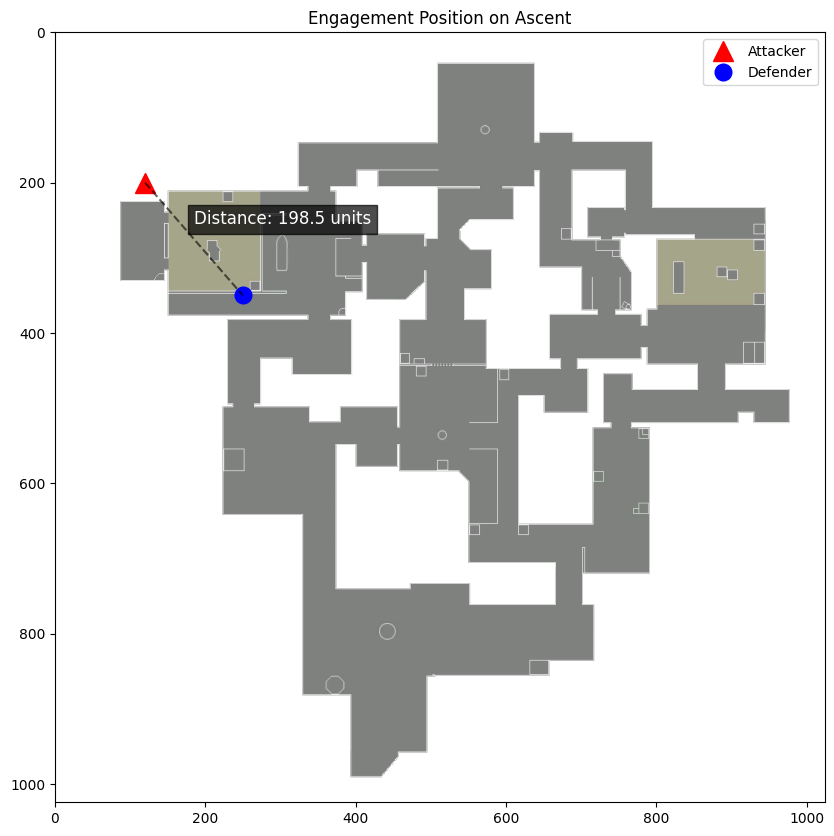

In [471]:
result = predict_duel(
    models["ascent"],
    attacker_pos=(120, 200),
    defender_pos=(250, 350),
    round_time=15000,
    plant_time=None,
    attacker_weapon=Weapon.VANDAL,
    defender_weapon=Weapon.PHANTOM,
    attacker_armor_id=2,
    defender_armor_id=1
)
print(f"Prediction: {result['prediction']}")
print(f"Attacker Win Probability: {result['attacker_win_probability']:.2f}")
print(f"Defender Win Probability: {result['defender_win_probability']:.2f}")
print(result['features_used'])

plot_positions_on_map(
    "ascent",
    attacker_pos=(120, 200),
    defender_pos=(250, 350)
)